# Lab 3
Lucas Street, 1874989

In [10]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas pyuvdata
# Also install https://github.com/HERA-Team/hera_cal

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

In [11]:
filename = '../Lab 5/zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)

def get_spectrogram(hd, selected_times, freq_channels, *args, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('Time (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])
    
def plot_histogram(times, frequency_channels, max_amplitude=0.4, polarization='XX'):
    all_antenna_data, _, _ = get_spectrogram(hd, times, frequency_channels, polarization)
    hist_data = np.abs(np.array(all_antenna_data).flatten())
    hist_data = hist_data[np.abs(hist_data) < max_amplitude]
    # print(len(hist_data))
    plt.title(f"Background distribution for time {times.round(4)}")
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    plt.hist(hist_data, bins=100, density=True);
    return hist_data

def plot_lognormal_fit(hist_data, max_amplitude=0.4):
    sigma, mean, scale = stats.lognorm.fit(hist_data)
    dist = stats.lognorm(sigma, mean, scale)
    x = np.linspace(0, max_amplitude, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, linewidth=4, alpha=0.8)
    plt.yscale('log')
    plt.xlim(0, max_amplitude)
    plt.ylim(1e-4)
    plt.legend(['Lognormal fit', 'Background'])
    print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")
    return sigma, mean, scale

## Problem 1

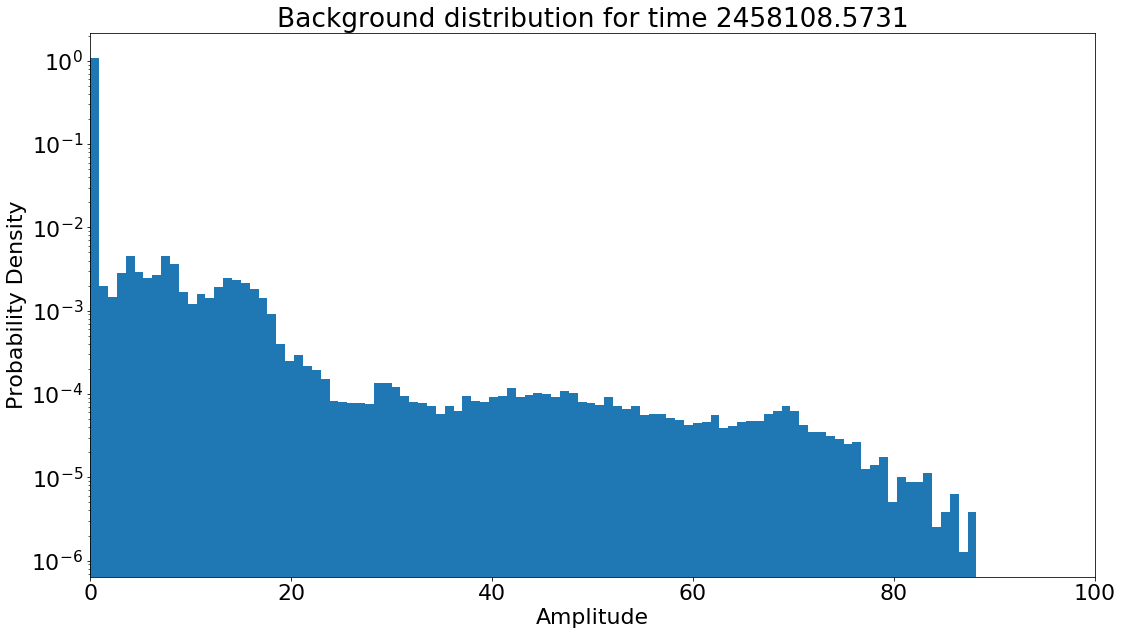

In [164]:
time = hd.times[1]
freq_channels = np.arange(150, 800)

plot_histogram(time, freq_channels, max_amplitude=100, polarization='XX')
plt.xlim(0, 100)
plt.yscale('log')

Lognormal: mu: -0.0024053702229698496, sigma: 0.8905486364744798, s: 0.0236767753597881


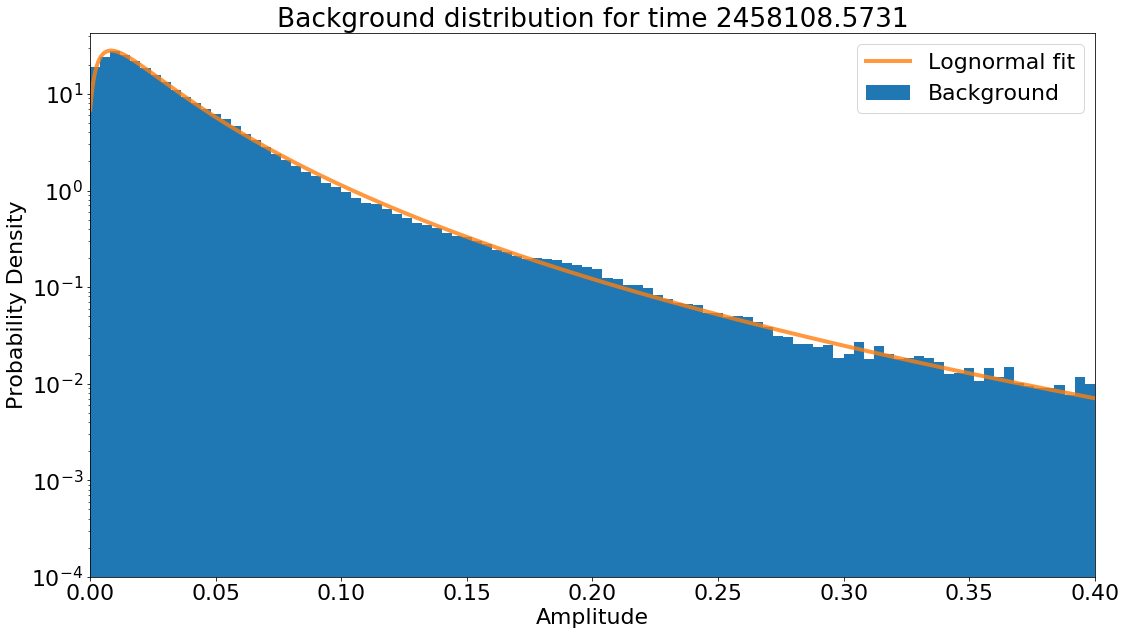

In [165]:
hist_data = plot_histogram(time, freq_channels, max_amplitude=0.4, polarization='XX')
sigma, mean, scale = plot_lognormal_fit(hist_data, max_amplitude=0.4)

In [166]:
dist = stats.lognorm(sigma, mean, scale)
dist.ppf(stats.norm.cdf(5))

2.030533628038701

## Problem 2

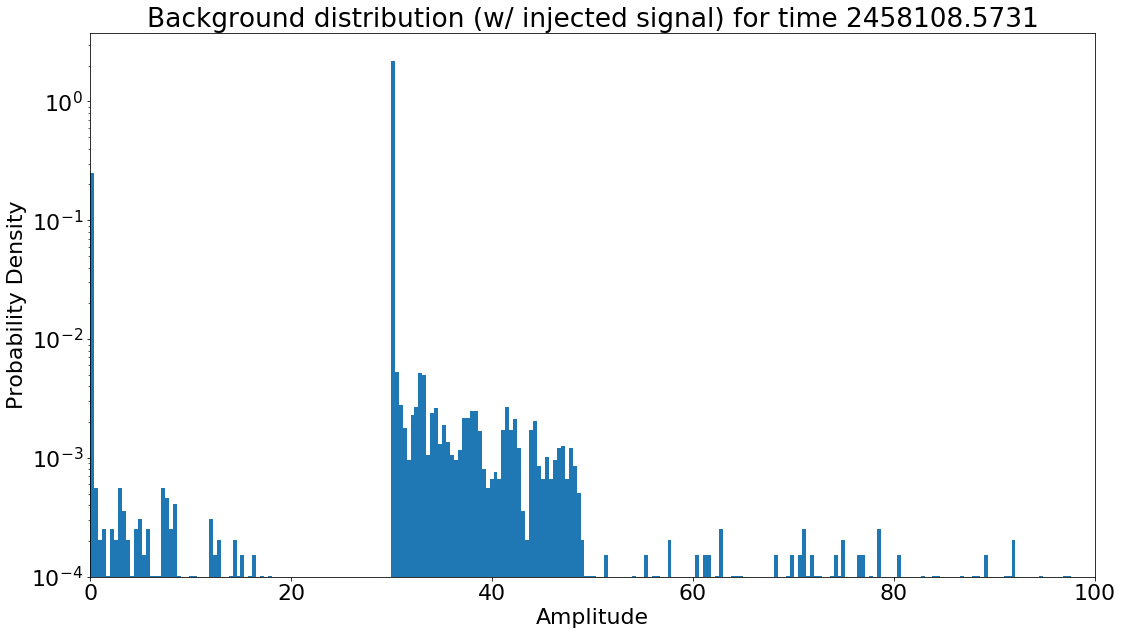

In [167]:
injection_rate = 0.90
signal_strength = 30.0
start, stop = 0, 50_000

background_data, _, _ = get_spectrogram(hd, time, freq_channels, 'XX')
background_data_flat = np.abs(np.array(background_data).flatten())
signal = (np.random.rand(background_data_flat.size) < injection_rate) * signal_strength
background_injected_const = background_data_flat + signal

plt.title(f"Background distribution (w/ injected signal) for time {time.round(4)}")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.hist(background_injected_const[start:stop], bins=300, density=True)
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(1e-4, None);

In [168]:
noise = np.abs(np.array(background_data)).flatten()[start:stop]
signal_locations = (np.random.rand(600, len(noise)) < injection_rate)
signal_strengths = np.linspace(0, 200, 600)
_, signal_strengths_grid = np.meshgrid(signal_locations[0, :], signal_strengths)
signal = signal_locations * signal_strengths_grid

observed = noise + signal

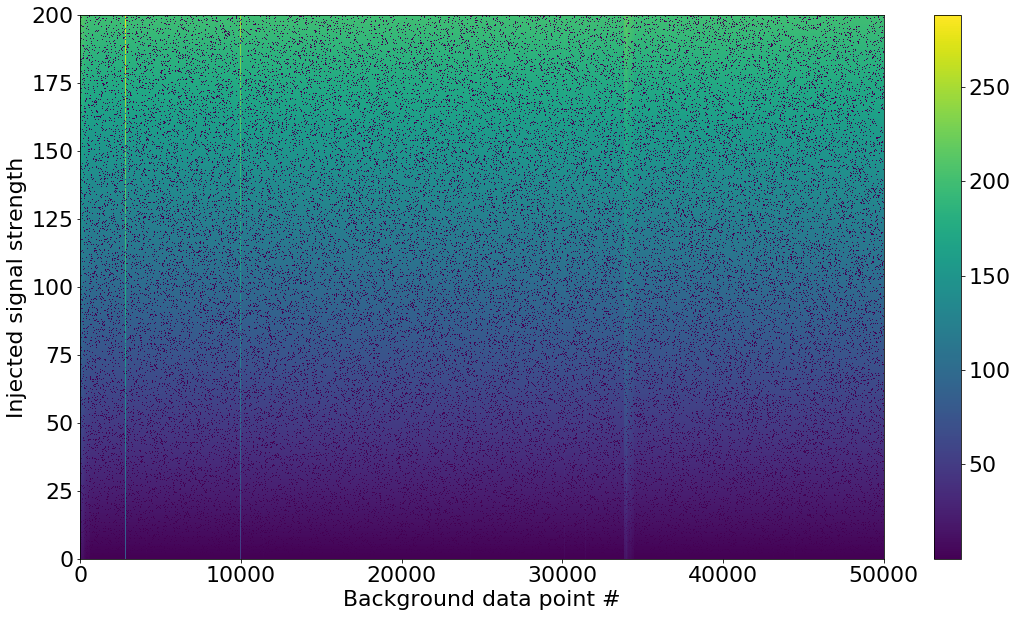

In [178]:
plt.xlabel('Background data point #')
plt.ylabel('Injected signal strength')
plt.imshow(observed, origin='bottom', extent=(0, stop - start, signal_strengths[0], signal_strengths[-1]))
plt.colorbar()
plt.gca().set_aspect('auto');

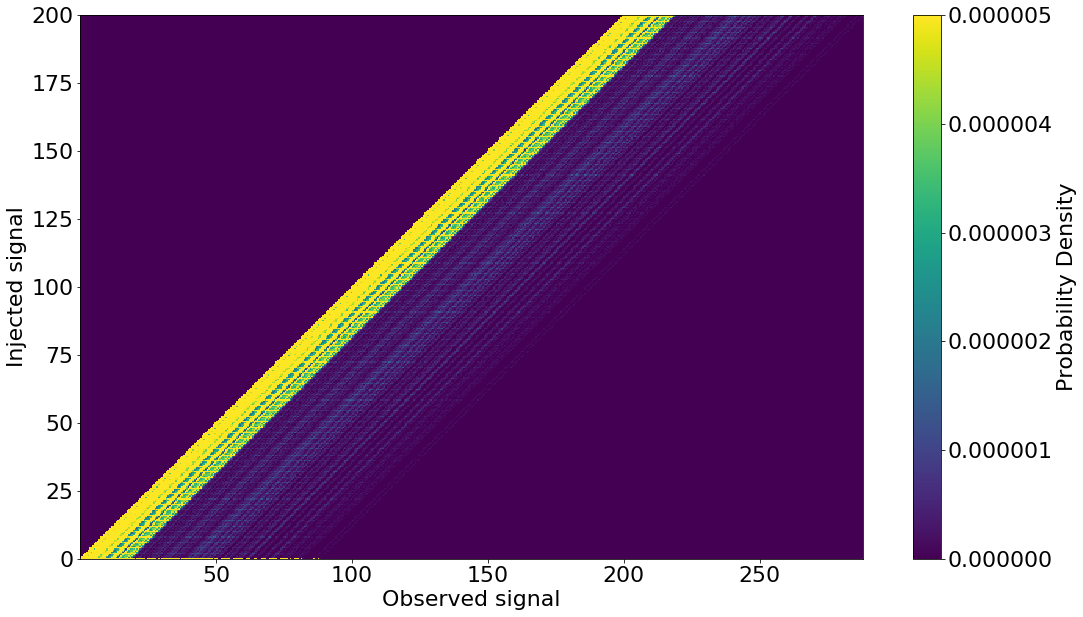

In [170]:
plt.xlabel('Observed signal')
plt.ylabel('Injected signal')
plt.hist2d(observed.flatten(), signal.flatten(), bins=500, density=True, vmax=5e-6)
cbar = plt.colorbar()
cbar.set_label('Probability Density')
plt.gca().set_aspect('equal');

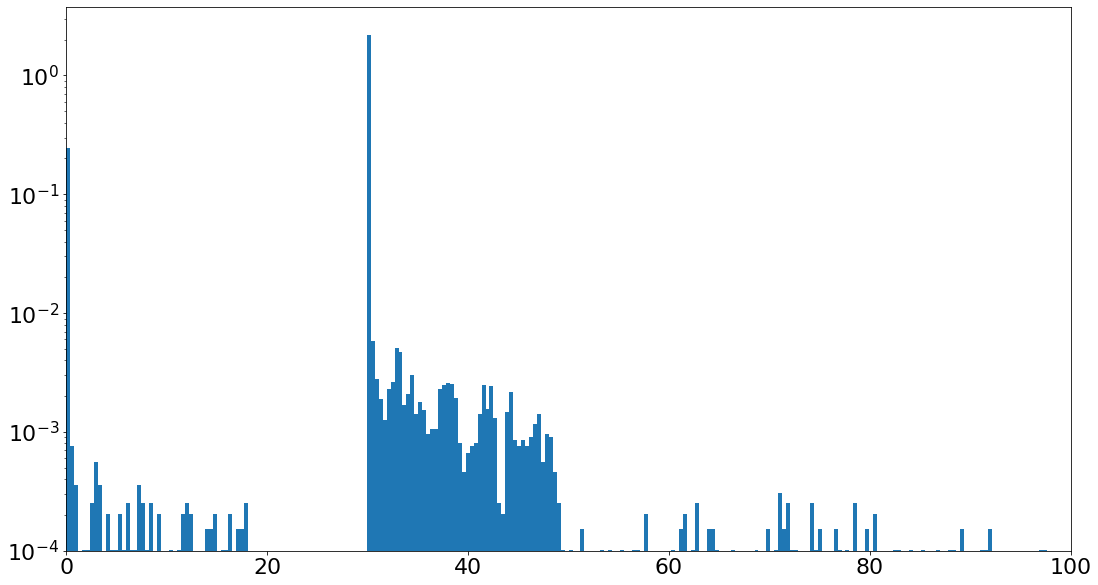

In [171]:
index = abs(signal_strengths - 30).argmin()
vals = observed[index, :]
plt.hist(vals, bins=300, density=True)
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(1e-4, None);

40163 points


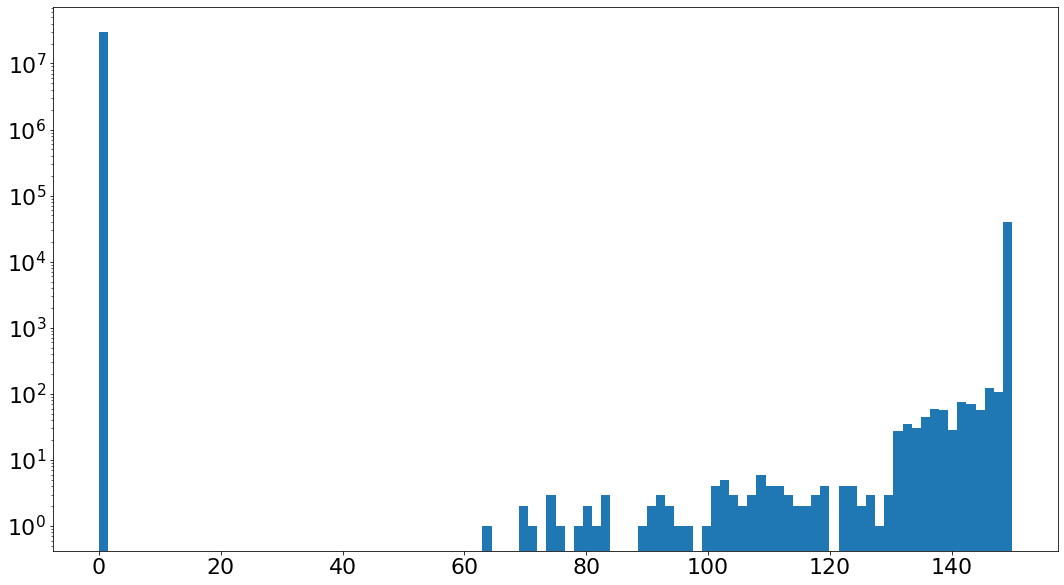

In [179]:
chosen_observation = 150
injected_locations = abs(observed - chosen_observation) < 0.08
print(injected_locations.sum(), 'points')
plt.hist((signal * injected_locations).flatten(), bins=100)
plt.yscale('log')